In [9]:
from keras.models import Input, Model
from keras.layers import Dense, LSTM, Embedding
from translator_helper import get_data_as_words, get_words_embedding_model, get_words_embedding_model_inference
import numpy as np
from nltk.translate.bleu_score import corpus_bleu

## Inference Model

In [19]:
num_samples = 28500 #10000
latent_dim = 128 #256
english_sentences, french_sentences, \
encoder_input_data, decoder_input_data, decoder_target_data, \
num_encoder_tokens, num_decoder_tokens, \
idx2Word_en, idx2Word_fr, \
word2Idx_en, word2Idx_fr = get_data_as_words(num_samples = num_samples)

model, encoder_model, decoder_model = get_words_embedding_model_inference(num_encoder_tokens, num_decoder_tokens, latent_dim = latent_dim)
model.summary()
encoder_model.summary()
decoder_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, None, 128)     556928      input_5[0][0]                    
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, None, 128)     1177344     input_6[0][0]                    
___________________________________________________________________________________________

In [33]:
#seq2seq_enc_dec_model_50
#seq2seq_enc_dec_model_256
#testing_256.hdf5
#name = 'seq2seq_enc_dec_model_128_28500.hdf5'
#name = 'seq2seq_enc_dec_model_'+str(latent_dim)+'.hdf5'
name = 'seq2seq_enc_dec_model_128_28500_best.hdf5'
print(name)
model.load_weights(name)

seq2seq_enc_dec_model_128_28500_best.hdf5


In [34]:
max_decoder_seq_length = decoder_target_data.shape[1]
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    target_seq = np.array([word2Idx_fr['<start>']])
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_char = idx2Word_fr[sampled_token_index]
        decoded_sentence = decoded_sentence + sampled_char + ' '

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<stop>' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.array([sampled_token_index])

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [35]:
### 0, 10, 19, 1000, 1001
def translate(sec_n = 0):
    input_seq = encoder_input_data[sec_n:sec_n+1]
    # print([idx2Word_en[word] for word in input_seq[0]])
    decoded_sentence = decode_sequence(input_seq)
    return decoded_sentence.replace('<stop>','').split(), \
        french_sentences[sec_n].replace('<START>','').replace('<STOP>','').lower().split()

In [36]:
def get_ref_and_cand(english_sentences, french_sentences, number_translations):
    english_sentences_np = np.array(english_sentences)
    french_sentences_as_list = [sen.replace('<START>','').replace('<STOP>','').lower().split() for sen in french_sentences]
    french_sentences_np = np.array(french_sentences_as_list)
    print('Creating references indexes')
    reference_indexes = []
    for eng_np in english_sentences_np:
        indxs = np.array(np.where(english_sentences_np==eng_np)[0])
        if (len(reference_indexes)>0):
            if len(reference_indexes[-1])!=len(indxs):
                result = 0
            else:
                result = (reference_indexes[-1] == indxs).prod()  
            if (result==0):
                reference_indexes.append(indxs)
        else:
            reference_indexes.append(indxs)
    print('Creating references and translating')
    references = []
    candidates = []
    count = 0
    for ref_idx  in reference_indexes[:number_translations]:
        reference = list(french_sentences_np[ref_idx])
        references.append(reference)
        candidates.append(translate(count)[0])
        count = count+len(reference)
    print('Created!')
    return references, candidates
references, candidates = get_ref_and_cand(english_sentences, french_sentences, 1000)

Creating references indexes
Creating references and translating
Created!


In [37]:
references[:10]

[[['va', '!']],
 [['cours', '!'], ['courez', '!']],
 [['ça', 'alors', '!']],
 [['au', 'feu', '!']],
 [['à', 'l', "'aide", '!']],
 [['saute', '.']],
 [['ça', 'suffit', '!'], ['stop', '!'], ['arrête-toi', '!']],
 [['attends', '!'], ['attendez', '!']],
 [['je', 'comprends', '.']],
 [['j', "'essaye", '.']]]

In [40]:
candidates[:10]

[['va', '!'],
 ['!'],
 ['à', 'c', "'est", 'à', 'vous'],
 ['au', 'l', 'train', 'de', 'feu'],
 ['arrête', '!'],
 ['vous', '.'],
 ['arrête', '!'],
 ['!'],
 ['je', 'me', 'sens', 'bien'],
 ['j', "'ai", 'été', 'vais', '.']]

In [39]:
score = corpus_bleu(references, candidates)
print(score)

0.3037798564756852


In [7]:
# 256 -> 0.6460807861583944 (1000 translations)
# 128 -> 0.6237477000548044 (1000 translations)
# 50 -> 0.6696083157220736 (1000 translations)

In [42]:
history = np.load('seq2seq_enc_dec_model_128_28500.npy')

In [44]:
from matplotlib import pyplot as plt

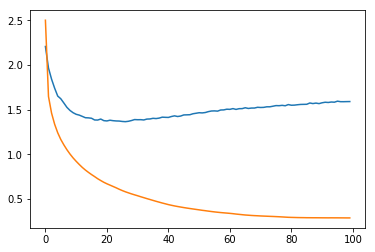

In [59]:
plt.plot(history.reshape(1)[0]['val_loss'])
plt.plot(history.reshape(1)[0]['loss'])
plt.show()